# Captcha recognition

## Description

There was the time when text captcha was used on many websites to check if you're a robot. But nowadays computers are able to solve this kind of captcha with rather good accuracy and i'll show you it in the project.
[Data](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images) was taken from open dataset of captcha images.

Было время, когда капча в виде текста встречалась очень часто на различных сайтах для проверки "на робота". Но сейчас машины способны проходить эту капчу с достаточно большой точной, что и будет предемонстрированно в данном проекте.
[Данные](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images) были взяты из открытого датасета изображений капчи.

### Import

In [1]:
import os
from itertools import groupby
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import cv2

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import CharErrorRate

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data preparation

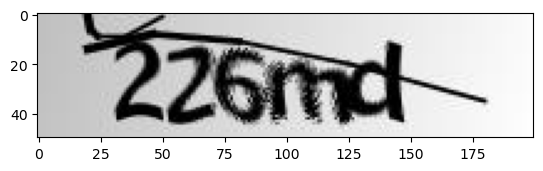

In [3]:
img = imread('/kaggle/input/captcha-version-2-images/samples/226md.png')
plt.imshow(img);

  0%|          | 0/1070 [00:00<?, ?it/s]

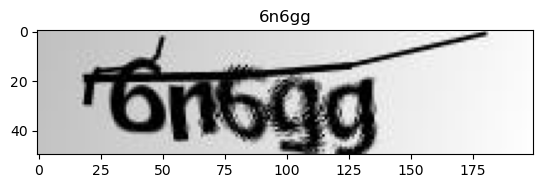

In [4]:
root = '/kaggle/input/captcha-version-2-images'
labels = []
images = []
for root, dirs, files in os.walk(os.path.join(root, 'samples')):
    labels = files

for file in tqdm(labels):
    images.append(imread(os.path.join(root, file)))

labels = [l[:-4] for l in labels]
plt.imshow(images[0])
plt.title(labels[0])
plt.show()

To work with the characters we should to encode it to integers.

Чтобы работать с символами мы должны закодировать их в int.

In [5]:
VOCAB = sorted(set(char for label in labels for char in label))
MAX_LEN = 0
for label in labels:
    MAX_LEN = max(MAX_LEN, len(label))
len(VOCAB), MAX_LEN

(19, 5)

In [6]:
def encode_to_labels(text):
    dig_lst = []
    
    for index, char in enumerate(text):
        try:
            dig_lst.append(VOCAB.index(char))
        except:
            print(char)
    dig_lst = dig_lst + [len(VOCAB) for _ in range(MAX_LEN - len(dig_lst))]
    return torch.LongTensor(dig_lst)

def get_text(label):
    text = ''
    for dig in label:
        try:
            text += VOCAB[dig]
        except:
            text = text
    return text

So, we have two functions to encode and decode captcha. Let's see how they work.

Итак, у нас есть две функции для кодирования и декодирования капчи. Посмотрим, как они работают.

In [7]:
encode_to_labels(labels[0]), labels[0], get_text(encode_to_labels(labels[0]))

(tensor([ 4, 14,  4, 12, 12]), '6n6gg', '6n6gg')

In [8]:
size = (64, 256)
X = [torch.FloatTensor(resize(cv2.cvtColor(img, cv2.COLOR_BGRA2BGR), size, mode='constant', anti_aliasing=True)) for img in images]
y = [encode_to_labels(captcha) for captcha in labels]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.25)
len(X_train), len(X_val)

(802, 268)

In [10]:
BATCH_SIZE = 128
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(list(zip(X_val, y_val)), batch_size=BATCH_SIZE)

In [11]:
def train(tr_dataloader, model, optim, loss_fn=nn.CTCLoss(blank=len(VOCAB), reduction='mean', zero_infinity=True), epochs=30):
    losses = []
    for epoch in tqdm(range(epochs)):
        model.train()
        loss_per_epoch = []
        for x_batch, y_batch in tr_dataloader:
            x_batch = x_batch.to(device)
            x_batch = x_batch.permute((0, 3, 2, 1))
            y_batch = y_batch.to(device)
            target_lengths = torch.IntTensor([len(y) for y in y_batch])
            optim.zero_grad()
            outp = model(x_batch)
            outp = outp.permute((1, 0, 2))
            input_lengths = torch.full(size=(len(y_batch),), fill_value=outp.shape[0], dtype=torch.long)
            l = loss_fn(outp, y_batch, input_lengths, target_lengths)
            l.backward()
            optim.step()
            loss_per_epoch.append(l.detach().cpu().numpy())
        losses.append(np.array(loss_per_epoch).mean())
        if (epoch + 1) % 10 == 0:
            print(f'Loss on {epoch + 1} epoch: {np.array(loss_per_epoch).mean()}')
    return losses

In [12]:
def test(dataloader, model):
    cer = CharErrorRate()
    for x_batch, y_batch in dataloader:
        y_batch = y_batch.to(device)
        x_batch = x_batch.to(device)
        model.eval()
        x_batch.type(torch.FloatTensor)
        x_batch = x_batch.permute((0, 3, 2, 1))
        with torch.no_grad():
            outp = model(x_batch)
        pred = ctc_decoder(outp.cpu())
        print(pred)
        print([get_text(y) for y in y_batch])
        print('CER:', cer(pred, [get_text(y) for y in y_batch]))

Output of our model for one captcha will be tensor containing information about probability of each character from vocabulary on each of 32 positions. We should choose max probability for each of these positions and after that delete repeating characters and blank symbols.

Результатом нашей модели для одной капчи будет тензор, содержащий информацию о вероятности появления каждого символа из словаря на каждой из 32 позиций. Мы должны выбрать максимальную вероятность для каждой из этих позиций и после этого удалить повторяющиеся символы и пустой символ.

In [13]:
def ctc_decoder(predictions):
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        for p in merged_list:
            if p != len(VOCAB):
                ans += VOCAB[int(p)]
        
        text_list.append(ans)
        
    return text_list

## Model

In [14]:
gru_hidden_size = 256
gru_num_layers = 2
cnn_output_height = 6
cnn_output_width = 30

In [15]:
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(32)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128)
        )
        
        self.gru_input_size = cnn_output_height * 128
    
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
    
        self.fc = nn.Linear(gru_hidden_size * 2, len(VOCAB) + 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.block1(x))
        out = F.relu(self.block2(out))
        out = F.relu(self.block3(out))
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [16]:
model = CRNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=len(VOCAB), reduction='mean', zero_infinity=True)

## Train

In [17]:
def train(tr_dataloader, model, optim, loss_fn=nn.CTCLoss(blank=len(VOCAB), reduction='mean', zero_infinity=True), epochs=30):
    losses = []
    for epoch in tqdm(range(epochs)):
        model.train()
        loss_per_epoch = []
        for x_batch, y_batch in tr_dataloader:
            x_batch = x_batch.to(device)
            x_batch = x_batch.permute((0, 3, 2, 1))
            y_batch = y_batch.to(device)
            target_lengths = torch.IntTensor([len(y) for y in y_batch])
            optim.zero_grad()
            outp = model(x_batch)
            outp = outp.permute((1, 0, 2))
            input_lengths = torch.full(size=(len(y_batch),), fill_value=outp.shape[0], dtype=torch.long)
            l = loss_fn(outp, y_batch, input_lengths, target_lengths)
            l.backward()
            optim.step()
            loss_per_epoch.append(l.detach().cpu().numpy())
        losses.append(np.array(loss_per_epoch).mean())
        if (epoch + 1) % 10 == 0:
            print(f'Loss on {epoch + 1} epoch: {np.array(loss_per_epoch).mean()}')
    return losses

In [18]:
losses = train(train_dataloader, model, optimizer, criterion, 250)

  0%|          | 0/250 [00:00<?, ?it/s]

Loss on 10 epoch: 3.117539882659912
Loss on 20 epoch: 1.3416290283203125
Loss on 30 epoch: 0.03838539123535156
Loss on 40 epoch: 0.009393368847668171
Loss on 50 epoch: 0.00533347949385643
Loss on 60 epoch: 0.003535029012709856
Loss on 70 epoch: 0.0024797730147838593
Loss on 80 epoch: 0.0019127825507894158
Loss on 90 epoch: 0.0014882931718602777
Loss on 100 epoch: 0.0012143664062023163
Loss on 110 epoch: 0.0009981774492189288
Loss on 120 epoch: 0.0008450705208815634
Loss on 130 epoch: 0.0007377409492619336
Loss on 140 epoch: 0.0006187387043610215
Loss on 150 epoch: 0.0005587069317698479
Loss on 160 epoch: 0.0004847208329010755
Loss on 170 epoch: 0.00043435749830678105
Loss on 180 epoch: 0.00038121428224258125
Loss on 190 epoch: 0.00034187620622105896
Loss on 200 epoch: 0.0003148173855151981
Loss on 210 epoch: 0.0002794399915728718
Loss on 220 epoch: 0.00026029153377749026
Loss on 230 epoch: 0.00023645169858355075
Loss on 240 epoch: 0.00022152651217766106
Loss on 250 epoch: 0.00019871164

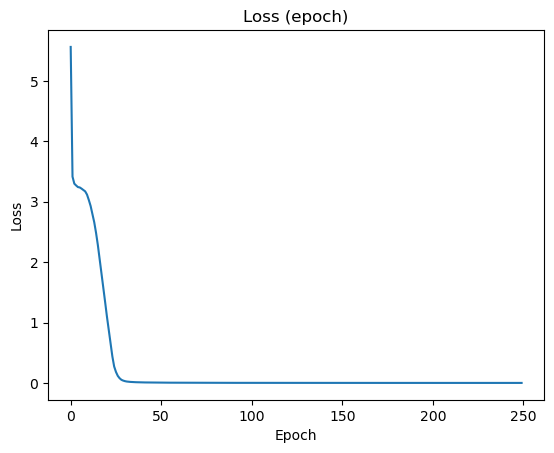

In [19]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (epoch)')
plt.show()

## Evaluation

In [35]:
def test(dataloader, model):
    cer = CharErrorRate()
    metric = []
    for x_batch, y_batch in dataloader:
        y_batch = y_batch.to(device)
        x_batch = x_batch.to(device)
        model.eval()
        x_batch.type(torch.FloatTensor)
        x_batch = x_batch.permute((0, 3, 2, 1))
        with torch.no_grad():
            outp = model(x_batch)
        pred = ctc_decoder(outp.cpu())
        metric.append(cer(pred, [get_text(y) for y in y_batch]).item())
    print('CER:', np.array(metric).mean())

In [36]:
test(val_dataloader, model)

CER: 0.1032986119389534


As we can see Character Error rate is near to 0 on validation data.

Как мы можем видеть, Character Error rate близка к 0 на валидационных данных

In [39]:
def random_visual(num=8):
    j = 0
    for x_batch, y_batch in val_dataloader:
        j += 1
        idx = np.random.randint(0, x_batch.shape[0], num)
        y_batch = y_batch[idx].to(device)
        x_batch = x_batch[idx].to(device)
        model.eval()
        x_batch.type(torch.FloatTensor)
        x_batch = x_batch.permute((0, 3, 2, 1))
        with torch.no_grad():
            outp = model(x_batch)
        pred = ctc_decoder(outp.cpu())
        fig, ax = plt.subplots(num // 4, 4, figsize=(20, 8))
        fig.tight_layout(pad=1.0)
        for i in range(num):
            ax[i // 4, i % 4].imshow(x_batch[i].cpu().permute(2, 1, 0))
            ax[i // 4, i % 4].set_title(pred[i])
        plt.show()
        if j == 1:
            break

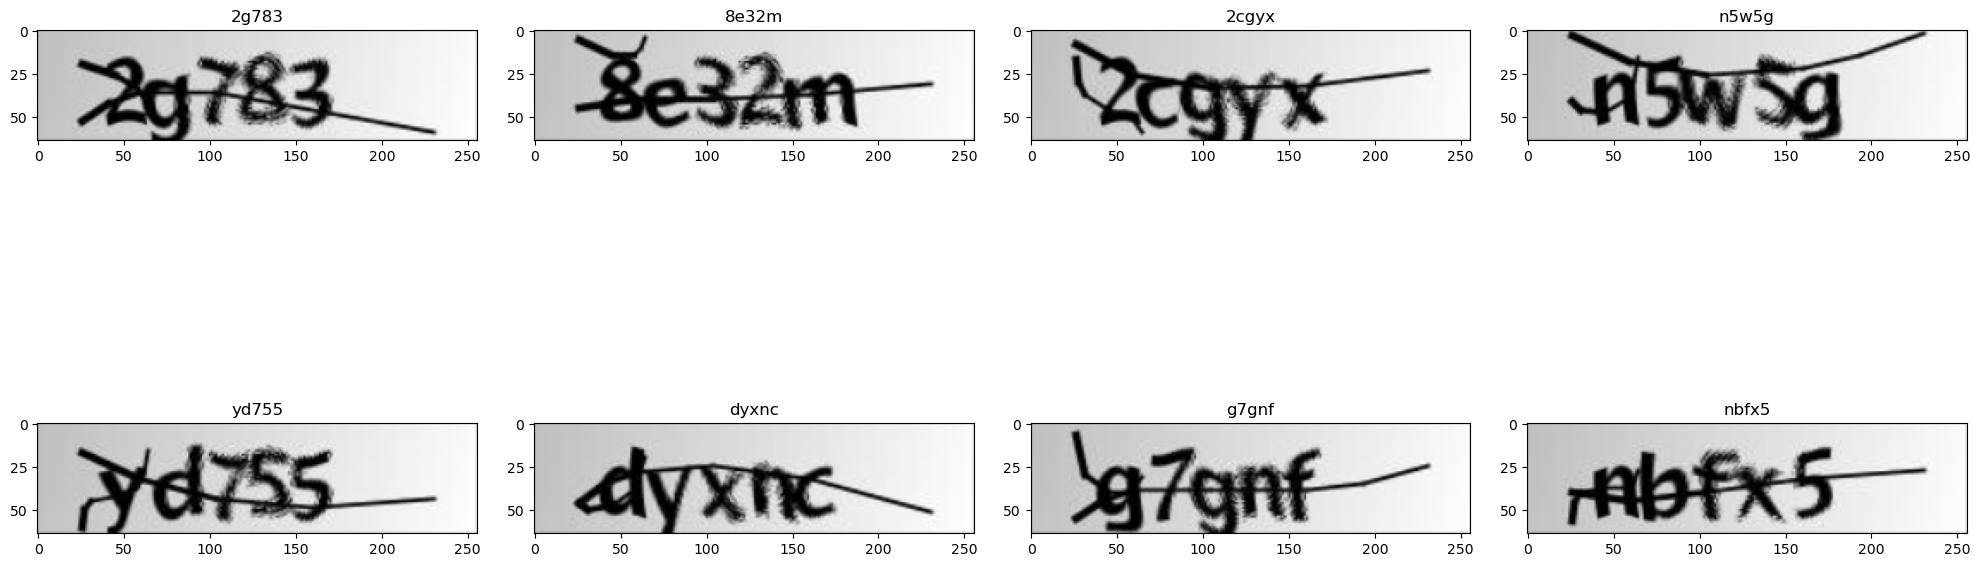

In [40]:
random_visual()